## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import sys, os, time, warnings, pdb, pickle, random, math, re, json
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm.notebook import tqdm

GLOBAL_SEED = 42
np.set_printoptions(precision=4)
sns.set_style("darkgrid")
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

## Data Exploration

In [2]:
train_df = pd.read_csv('../data/fraud/fraudTrain.csv', index_col=0)
test_df = pd.read_csv('../data/fraud/fraudTest.csv', index_col=0)
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
# print(train_df.shape, test_df.shape)
# print(train_df.columns, test_df.columns)

is_fraud
0   0.99
1   0.01
Name: proportion, dtype: float64


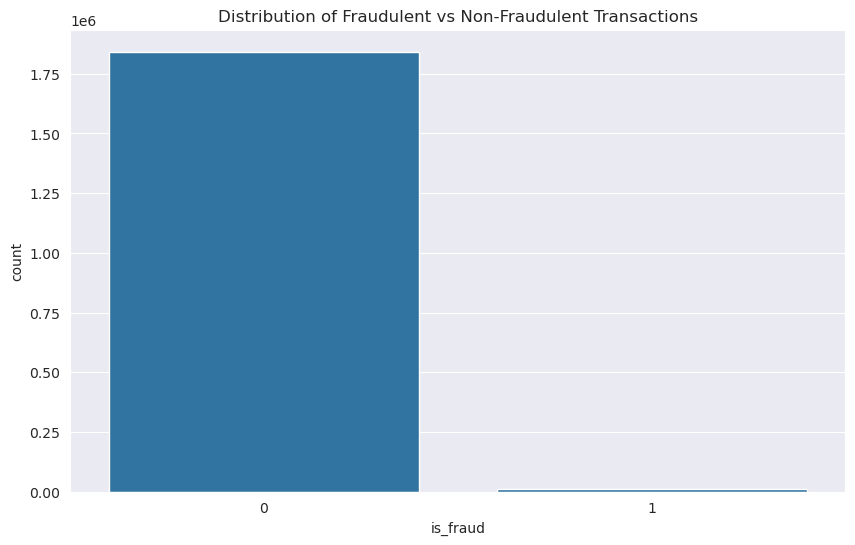

Percentage of fraudulent transactions: 0.52%


In [3]:
# Fraud distribution
fraud_dist = df['is_fraud'].value_counts(normalize=True)
print(fraud_dist)

plt.figure(figsize=(10, 6))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# Fraud percentage
fraud_percentage = (df['is_fraud'].sum() / len(df)) * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")

In [4]:
# Extract hour and day of week
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

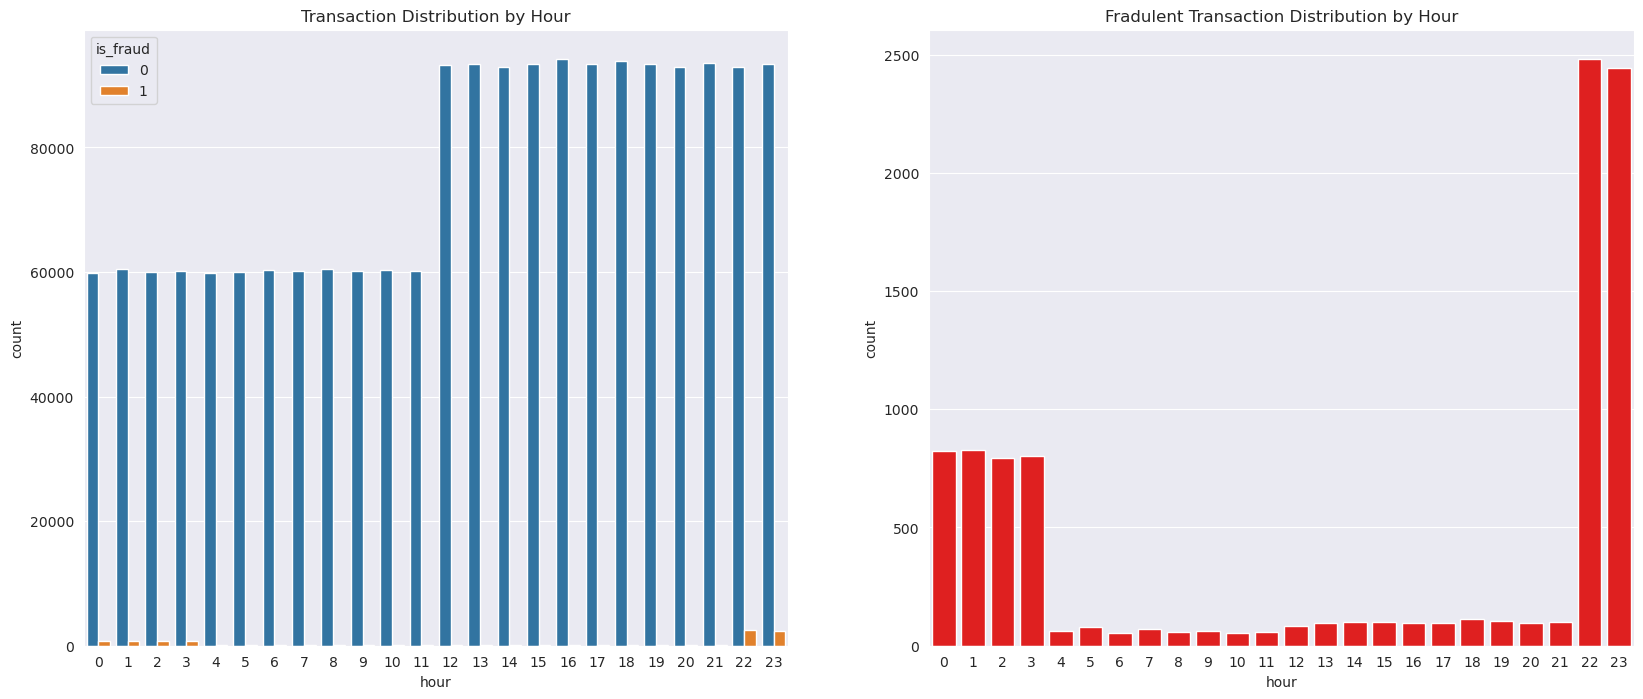

In [5]:
fig, ax = plt.subplots(1,2,figsize=(20, 8))
sns.countplot(x='hour', hue='is_fraud', data=df, ax=ax[0])
sns.countplot(x='hour', data=df[df['is_fraud']==1], color='red', ax=ax[1])
ax[1].set_title('Fradulent Transaction Distribution by Hour')
ax[0].set_title('Transaction Distribution by Hour')
plt.show()

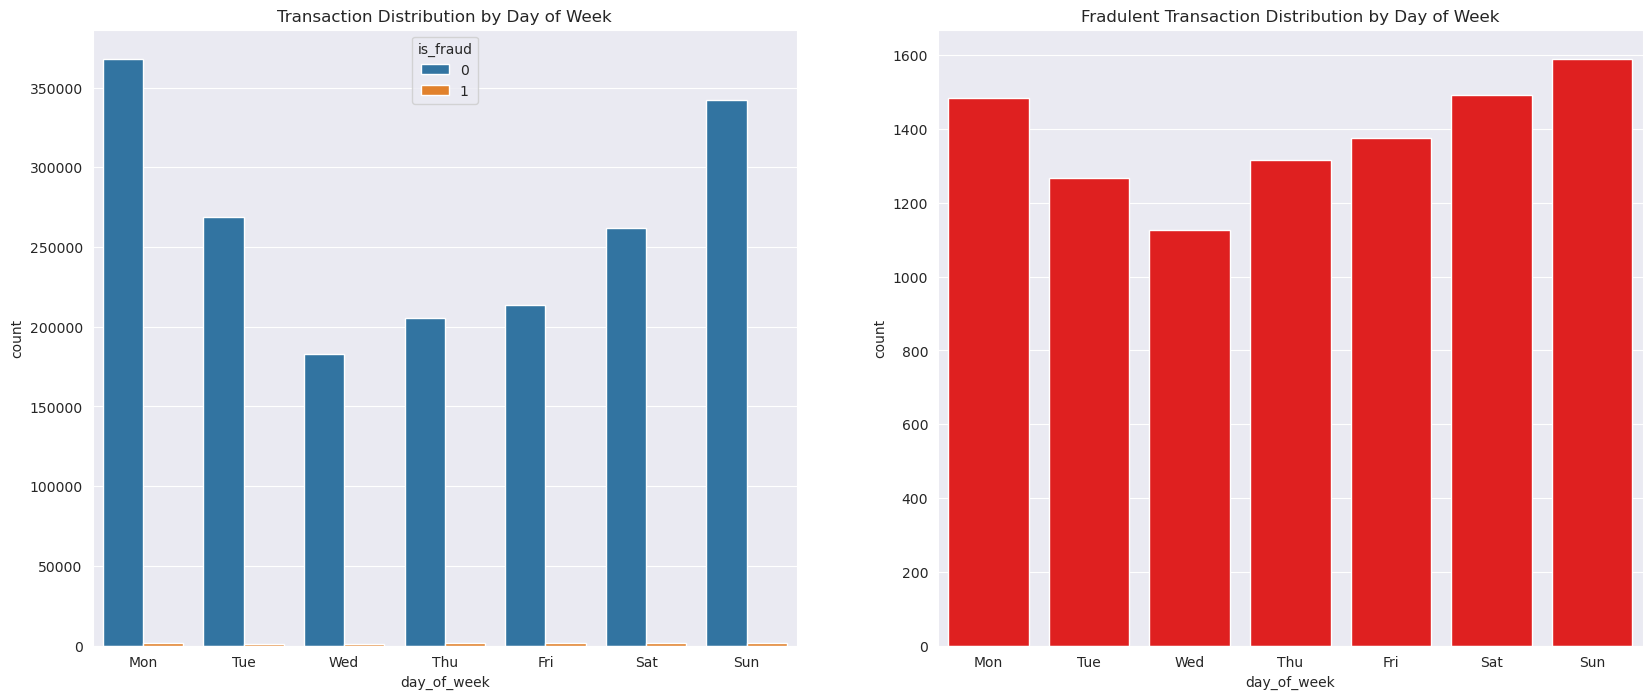

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20, 8))
sns.countplot(x='day_of_week', hue='is_fraud', data=df, ax=ax[0])
sns.countplot(x='day_of_week', data=df[df['is_fraud']==1], color='red', ax=ax[1])
ax[1].set_title('Fradulent Transaction Distribution by Day of Week')
ax[0].set_title('Transaction Distribution by Day of Week')
ax[0].set_xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax[1].set_xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

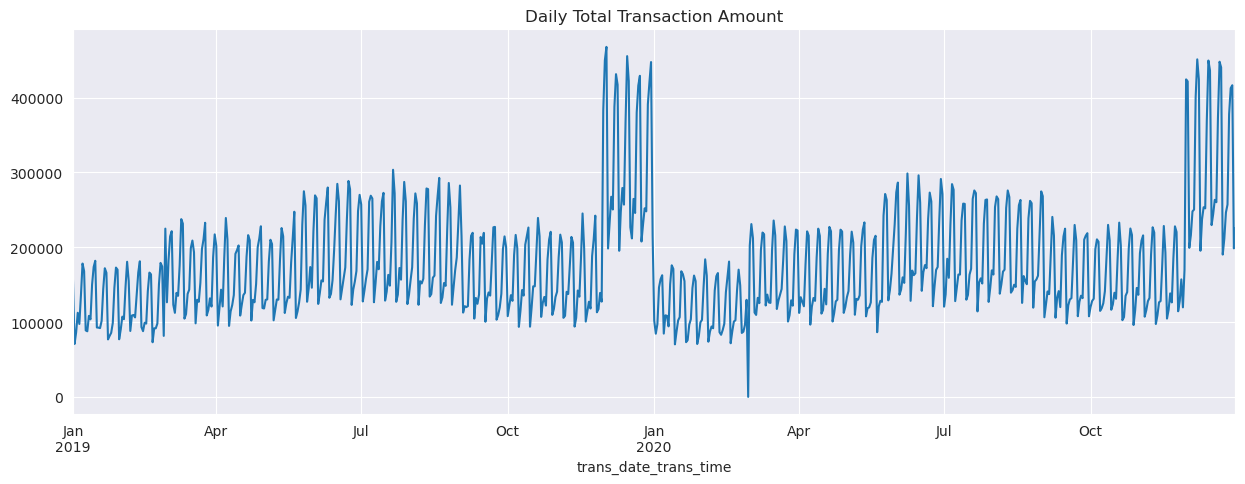

In [7]:
# Time series of transaction amounts
df.set_index('trans_date_trans_time', inplace=True)
df.resample('D')['amt'].sum().plot(figsize=(15, 5))
plt.title('Daily Total Transaction Amount')
plt.show()

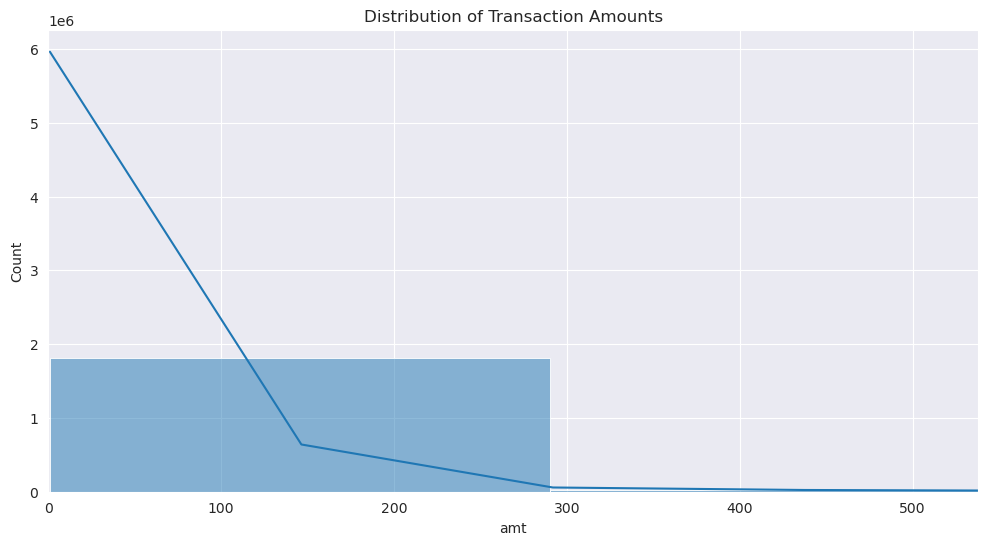

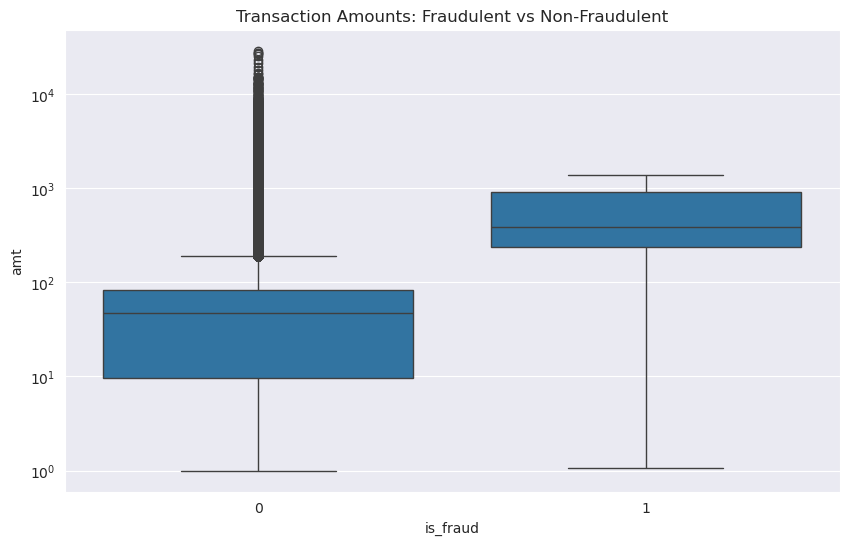

Fraudulent transaction amount statistics:
count   9651.00
mean     530.66
std      391.03
min        1.06
25%      240.07
50%      390.00
75%      902.37
max     1376.04
Name: amt, dtype: float64

Non-fraudulent transaction amount statistics:
count   1842743.00
mean         67.65
std         153.55
min           1.00
25%           9.61
50%          47.24
75%          82.56
max       28948.90
Name: amt, dtype: float64


In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(df['amt'], bins=100, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlim(0, df['amt'].quantile(0.99))  # Limit x-axis to 99th percentile
plt.show()

# Box plot of amounts for fraudulent vs non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.title('Transaction Amounts: Fraudulent vs Non-Fraudulent')
plt.yscale('log')
plt.show()

# Calculate and print statistics
fraud_stats = df[df['is_fraud'] == 1]['amt'].describe()
non_fraud_stats = df[df['is_fraud'] == 0]['amt'].describe()
print("Fraudulent transaction amount statistics:")
print(fraud_stats)
print("\nNon-fraudulent transaction amount statistics:")
print(non_fraud_stats)

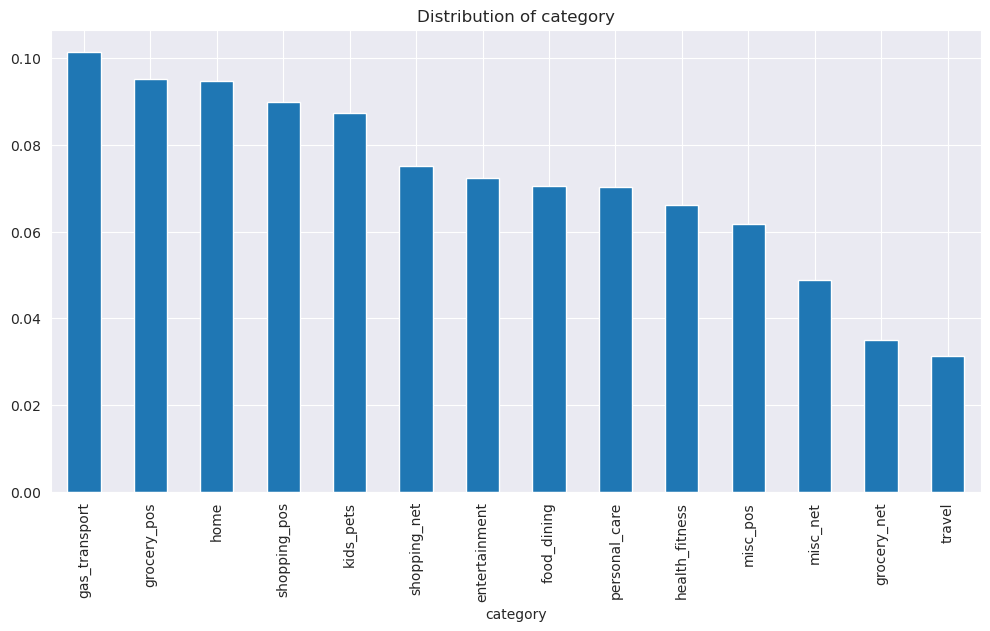

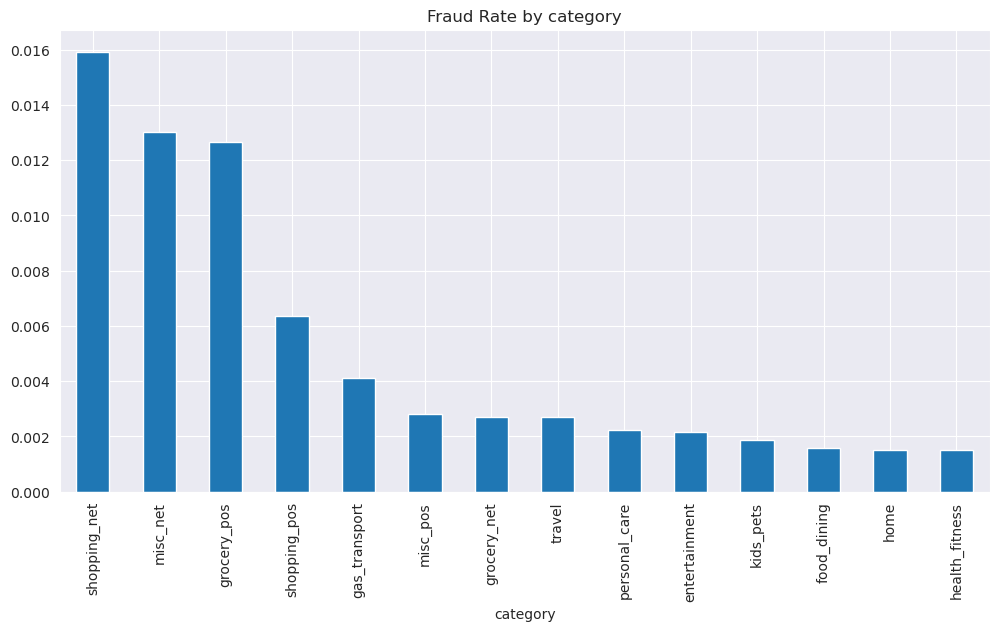

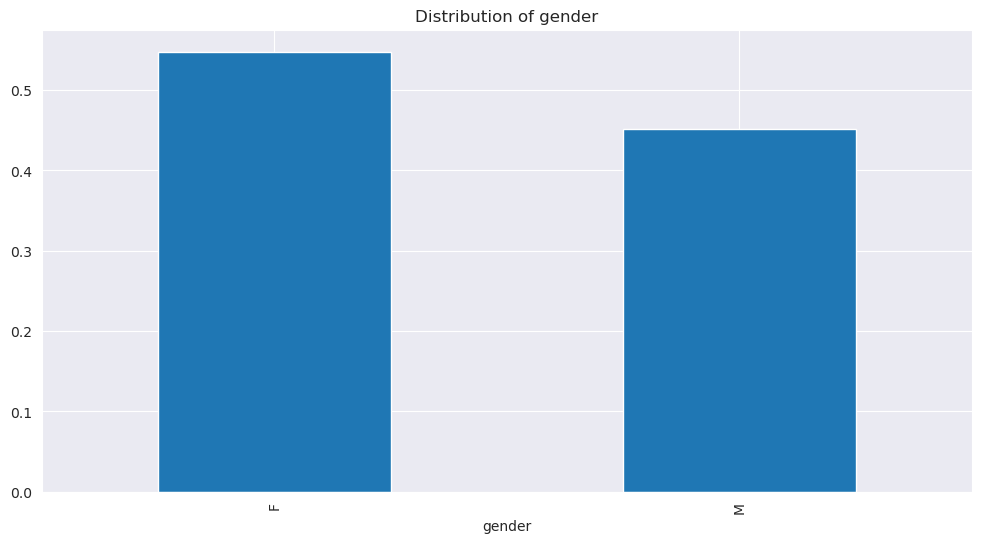

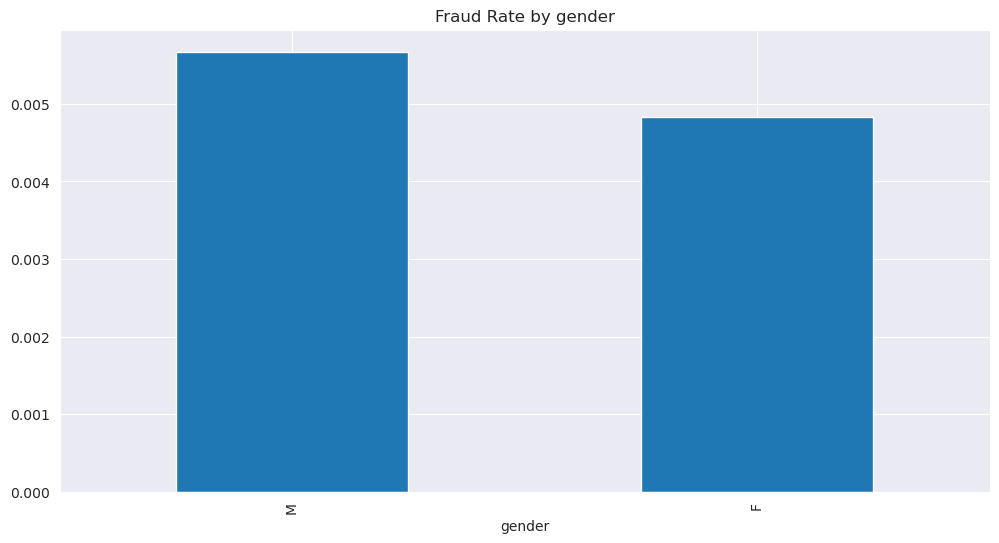

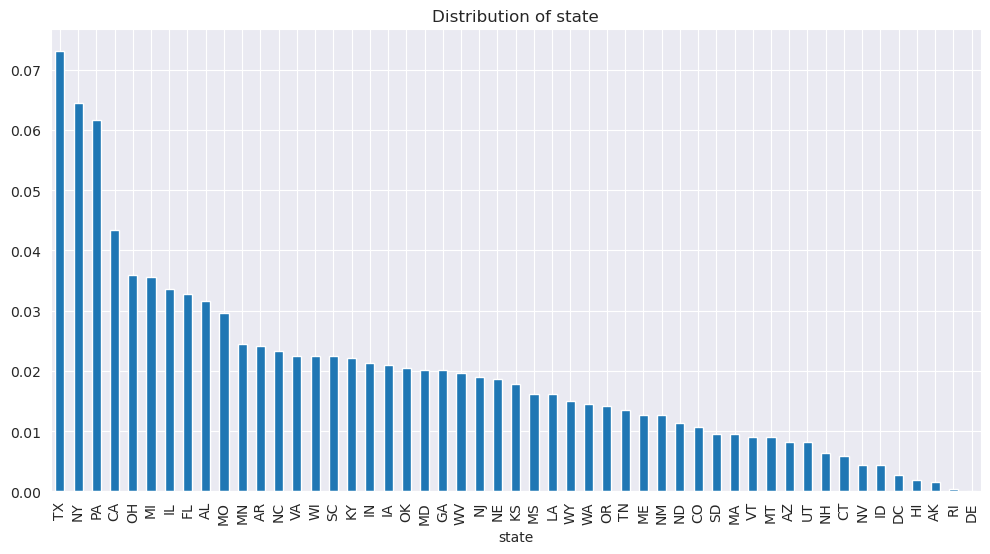

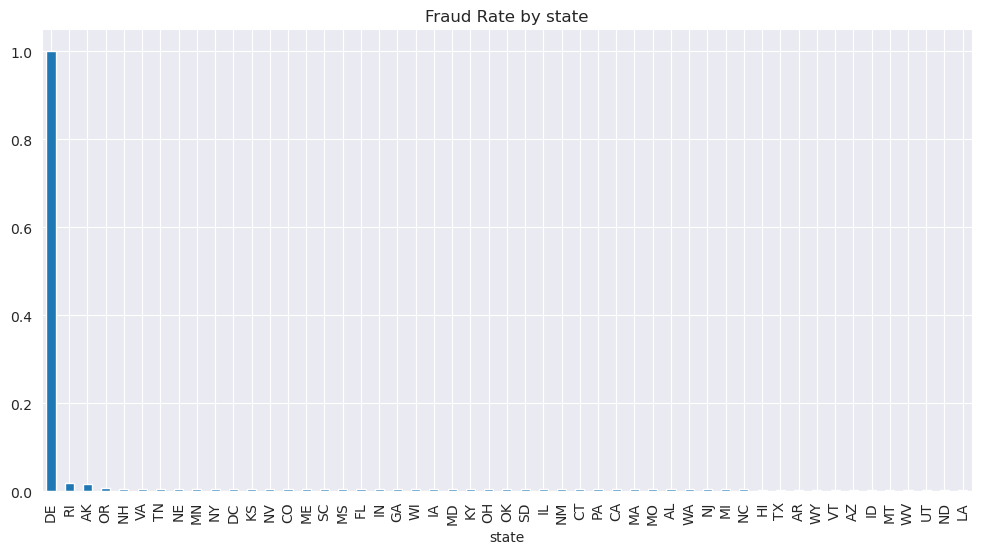

In [9]:
categorical_cols = ['category', 'gender', 'state']

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()
    
    # Fraud rate by category
    fraud_rate = df.groupby(col)['is_fraud'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    fraud_rate.plot(kind='bar')
    plt.title(f'Fraud Rate by {col}')
    plt.xticks(rotation=90)
    plt.show()

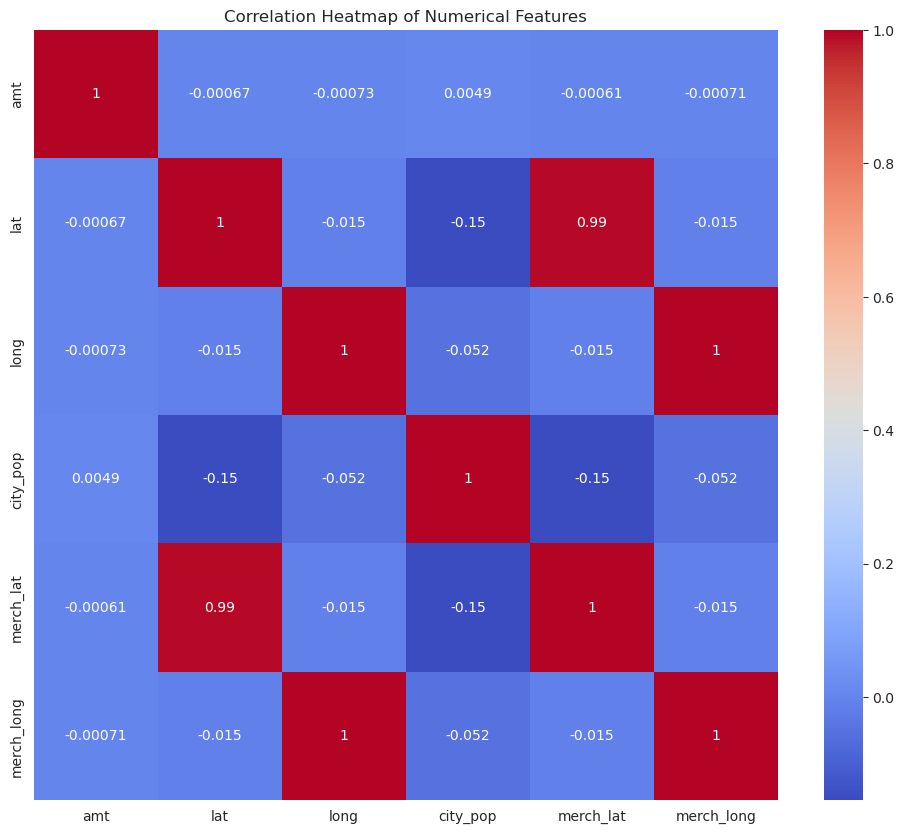

In [11]:
numeric_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

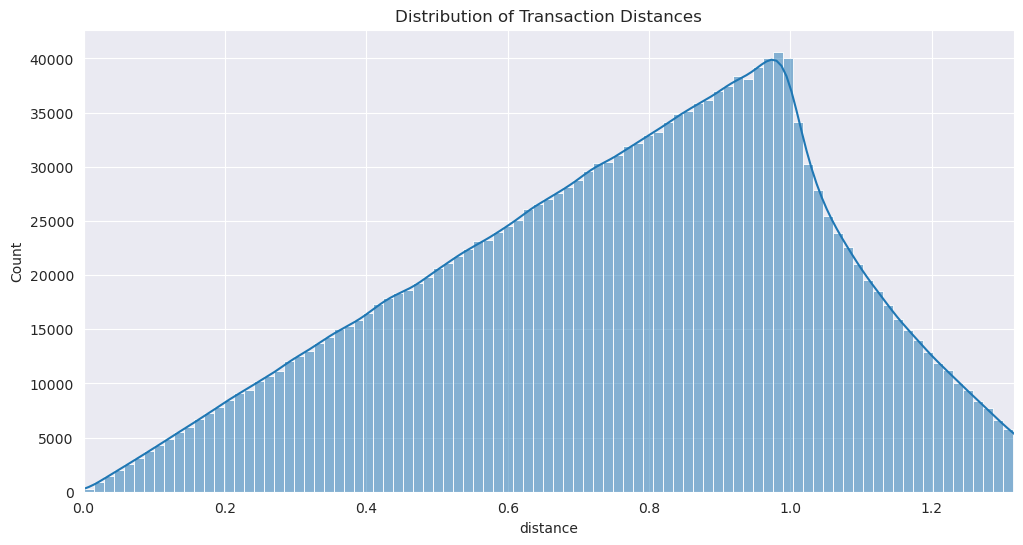

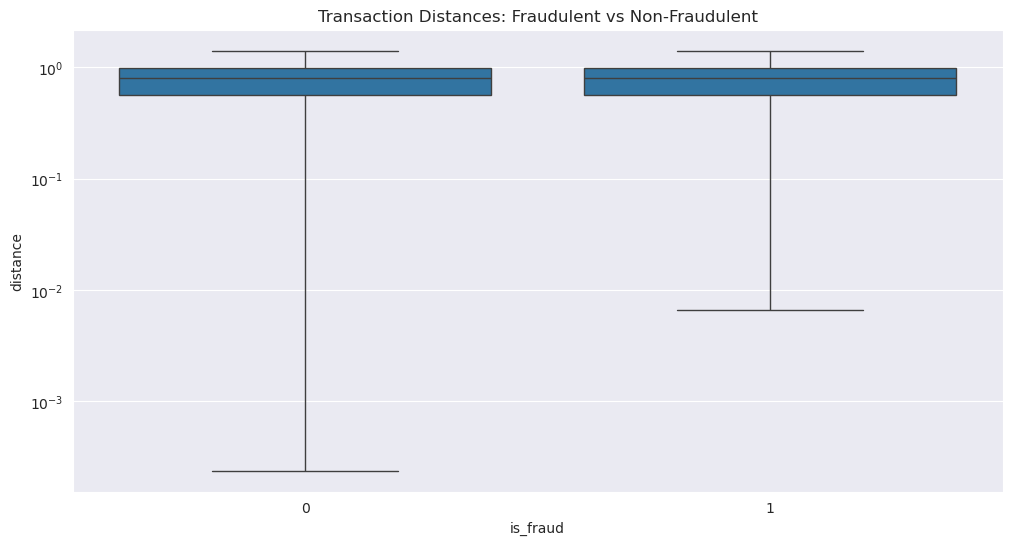

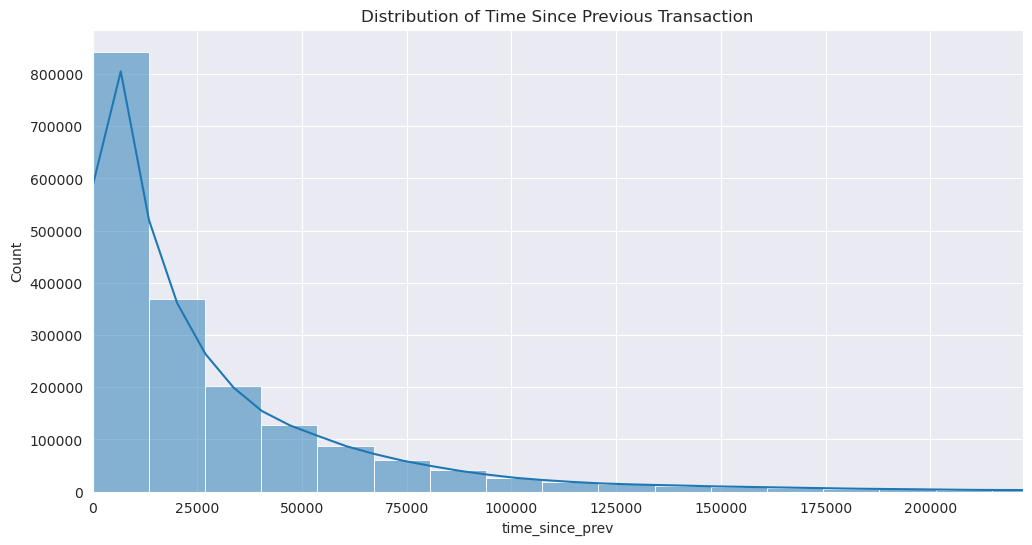

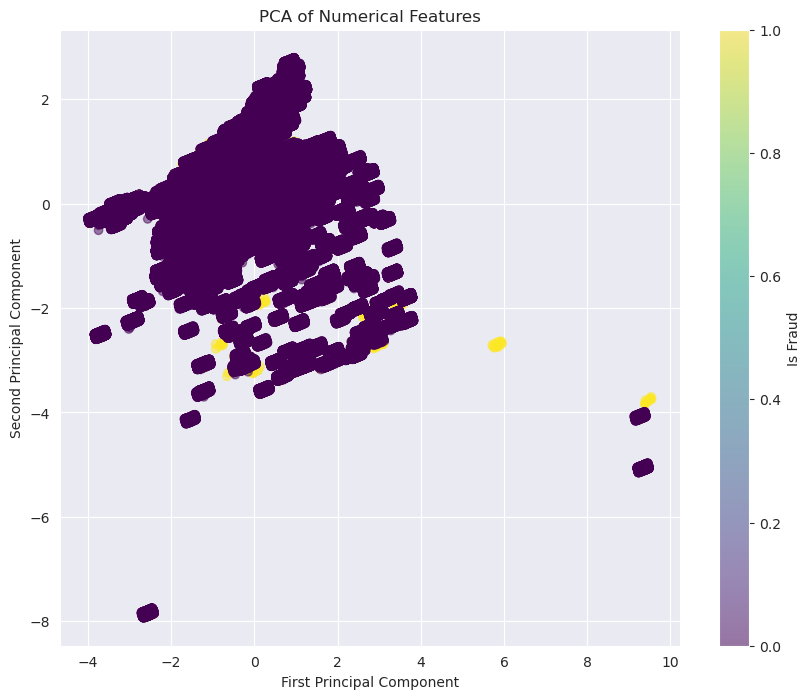

In [17]:
# Calculate distance between customer and merchant
df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

# Time since previous transaction
df['time_since_prev'] = df.groupby('cc_num')['unix_time'].diff()

# Analyze these new features
plt.figure(figsize=(12, 6))
sns.histplot(df['distance'], bins=100, kde=True)
plt.title('Distribution of Transaction Distances')
plt.xlim(0, df['distance'].quantile(0.99))
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='is_fraud', y='distance', data=df)
plt.title('Transaction Distances: Fraudulent vs Non-Fraudulent')
plt.yscale('log')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['time_since_prev'].dropna(), bins=100, kde=True)
plt.title('Distribution of Time Since Previous Transaction')
plt.xlim(0, df['time_since_prev'].quantile(0.99))
plt.show()

# PCA for dimensionality reduction and visualization
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'distance']
X = StandardScaler().fit_transform(df[numeric_features])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['is_fraud'], cmap='viridis', alpha=0.5)
plt.title('PCA of Numerical Features')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Is Fraud')
plt.show()